In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer

import string
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

In [2]:
def get_unique_words(text):
    words = [word for message in text for word in message]
    return set(words)

def co_occurence_matrix_with_window(text, window_size, stop_words):
    '''
    Calculates the co-occurence matrix using a sliding window of size window_size as context    
    Output is (unique) words x (unique) words
    '''
    unique_words = get_unique_words(text)
    n = len(unique_words) #number of unique words
    co_matrix = pd.DataFrame(data=np.zeros([n,n]), columns=unique_words, index=unique_words, dtype='int')

    #for each word in each message, counts +1 for each pair [word,context] 
    #words considered context are defined by the window size
    for message in text:
        msg_len = len(message)
        for i, word in enumerate(message):
            first = max(i - window_size, 0)
            last = min(i + window_size + 1, msg_len)
            for context in message[first:last]:
                co_matrix.loc[word,context] += 1
    return co_matrix  
    
def word_occurence_matrix(text, target=None, stop_words=None, binary=True):  
    '''
    Output is messages x (unique) words
    
    If binary=True, then each element represents if the word is in the message or not.
    Otherwise, it represents the count of how many times that word appears in that message.
    '''
    preprocessor = CountVectorizer(strip_accents='unicode').build_preprocessor()
    stop_words = [preprocessor(word) for word in stop_words] #preprocesses stop words
    if target:
        target = preprocessor(target) #preprocesses target word
        text = text[text.str.contains(target)] #Filter comments in which target word is present
        
    #calculates word count for each message
    vectorizer = CountVectorizer(strip_accents='unicode', stop_words=stop_words, binary=binary)
    X = vectorizer.fit_transform(text).toarray()
    
    labels = vectorizer.get_feature_names()
    
    return X, labels

def co_occurence_matrix(word_occurence_matrix):
    '''
    Co-occurence matrix created based on the word count/occurence matrix.     
    In other words, this co-occurence matrix will consider each message as the context for all words in it.
    '''
    co_X = np.vstack(X)
    co_X = co_X @ co_X.T
    np.fill_diagonal(co_X, 0)
    return co_X

### Load data

In [9]:
data = pd.read_csv('../comentarios.csv', usecols=['text'])['text'].dropna()
stop_words = [word.rstrip() for word in open('stopwords.txt')]
N = 30 #Consider only the N most frequent words

### Co-occurence

In [10]:
X, labels = word_occurence_matrix(data, target='virus', stop_words=stop_words)

word_count = X.sum(axis=0) #no. of comments containing A in which each word appears
word_count = sorted(zip(labels, word_count), reverse=True, key=lambda tupl : tupl[1])
print(f'{N} palavras que mais ocorrem nos mesmos comentários em que "vírus" ocorre:')
print(word_count[:N])

30 palavras que mais ocorrem nos mesmos comentários em que "vírus" ocorre:
[('virus', 692), ('coronavirus', 632), ('corona', 164), ('dias', 154), ('pessoas', 154), ('pra', 154), ('dr', 152), ('https', 146), ('pode', 140), ('ivermectina', 136), ('sintomas', 128), ('agora', 126), ('sobre', 124), ('todos', 123), ('ainda', 122), ('covid', 115), ('vai', 115), ('video', 104), ('dia', 95), ('cura', 93), ('bem', 91), ('casa', 91), ('medico', 91), ('saude', 90), ('drauzio', 89), ('vc', 89), ('19', 88), ('brasil', 86), ('deus', 86), ('falta', 84)]


In [11]:
X, labels = word_occurence_matrix(data[:10000], stop_words=stop_words) #using only data[:10000] bc data is too big

#Selects only the N most frequent words. Otherwise, co_X would be giant
word_count = X.sum(axis=0)
most_freq_zipped = sorted(zip(word_count, labels, X.T), reverse=True)[:N]
word_count, labels, X = zip(*most_freq_zipped)

co_X = co_occurence_matrix(X)

In [12]:
print("30 palavras que mais ocorrem:")
print(list(zip(labels, word_count)))

30 palavras que mais ocorrem:
[('dias', 1516), ('deus', 1369), ('olfato', 1067), ('paladar', 1062), ('pra', 834), ('sintomas', 814), ('dor', 803), ('cheiro', 749), ('nada', 707), ('vc', 701), ('covid', 670), ('dia', 668), ('virus', 649), ('amem', 641), ('vai', 640), ('febre', 631), ('bem', 628), ('ainda', 618), ('to', 603), ('sinto', 597), ('dr', 586), ('sentir', 580), ('tudo', 533), ('cabeca', 525), ('assim', 513), ('ta', 500), ('gosto', 464), ('falta', 464), ('todos', 462), ('lair', 460)]


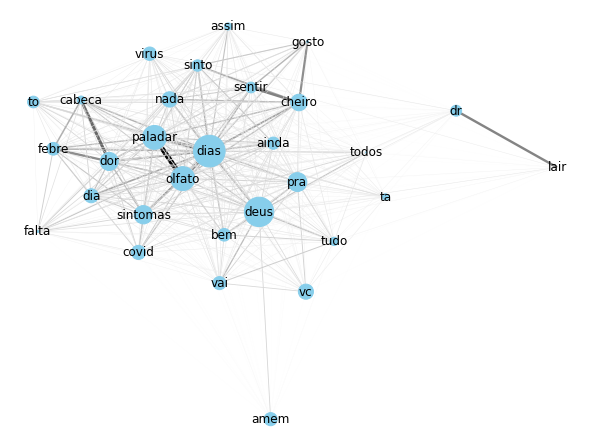

In [56]:
G = nx.Graph()

for i, row in enumerate(co_X):
    for j, co in enumerate(co_X[i]):
        G.add_edge(labels[i], labels[j], weight=(co))
        
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
norm_weights = (weights - min(weights)) / (max(weights) - min(weights))
norm_count = (word_count - min(word_count)) / (max(word_count) - min(word_count))

plt.figure(figsize=(8,6))
nx.draw(G, with_labels=True, node_color='skyblue', edgelist=edges, width=norm_weights*5, 
        edge_color=norm_weights, edge_cmap=cm.get_cmap('binary'), node_size=norm_count*1000,
        pos = nx.spring_layout(G, k=1))
plt.show()